In [1]:
import re
import math
import glob
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d
import freud
from matplotlib import collections, colors, transforms
import networkx as nx

In [2]:
def get_checkpoints(dir):
    filelist = glob.glob(dir+"/positions_*.bin")
    g = lambda x: x.split("_")[-1].split(".")[0]
    checkpoints = [ int(g(l)) for l in filelist]
    checkpoints.sort(reverse = True)
    return checkpoints
    
def get_param_from_dir(dir):
    subdir = dir.split("/",5)[-1]
    ptype, paramstring = subdir.split("_",1)
    return ptype, re.findall(r"[-+]?\d*\.\d+|\d+\d?", paramstring)

def get_state():
    pos = np.fromfile(dir+"/{}_{}.bin".format('positions', cp))
    #pos = np.reshape(pos, (-1,3))
    #print(pos)
    #print(np.shape(pos))

    orient = np.fromfile(dir+"/{}_{}.bin".format('orientations', cp))
    orient = np.reshape(orient, (-1,5))[:,4]
    #print(np.shape(orient))

    box = np.fromfile(dir+"/{}_{}.bin".format('Box', cp))
    #box_xy = box[3:5]
    #print(box_xy)
    
    N_particles = len(orient)
    return N_particles, np.reshape(pos, (-1,3)), orient, box[3:5]
    

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta) 
    R = np.array(((c, -s), (s, c)))

    return R
    
def get_orient(v, rot_mat):
    return rot_mat.dot(v)

def get_triangle_vertices_i(pos_i, orient_i):
    vertices = np.zeros((3,3))

    l2 = 0.5
    h2_small = np.sqrt(3)/6
    h2_large = 2*h2_small

    rotmat_i = rotation_matrix(orient_i)
    ax0 = np.array([[-l2, l2, 0], [-h2_small, -h2_small, h2_large]])

    ax_n = get_orient(ax0, rotmat_i).T

    vertices[0,0:2] = pos_i[0:2] + ax_n[0]
    vertices[1,0:2] = pos_i[0:2] + ax_n[1]
    vertices[2,0:2] = pos_i[0:2] + ax_n[2]

    return vertices

def get_number_of_patches(type):
    if(type=="6patch"):
        #six_patch
        return 6
    elif(type=="3asym"):
        #three_asymm
        return 3
    elif(type=="vo"):
        #veritce_opposite
        return 2
    elif(type=="vn"):
        #vertice_neighbour
        return 2
    elif(type=="2asym_c"):
        #two_asymm_center
        return 3
    elif(type=="mouse"):
        #mouse
        return 3
    else:
        print("Type not defined in function get_number_of_patches. Returned 0.")
        return 0

def get_patch_pos_i(vertices_i, type, delta):
    if(type=="6patch"):
        #six_patch
        patch_pos = np.zeros((6,3))
        patch_pos[0] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * delta
        patch_pos[1] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * (1 - delta)
        patch_pos[2] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * delta
        patch_pos[3] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * (1 - delta)
        patch_pos[4] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * delta
        patch_pos[5] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * (1 - delta)

    elif(type=="3asym"):
        #three_asymm
        patch_pos = np.zeros((3,3))
        patch_pos[1] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * delta
        patch_pos[2] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * delta
        patch_pos[0] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * delta

    elif(type=="vo"):
        #veritce_opposite
        patch_pos = np.zeros((2,3))
        patch_pos[0] = vertices_i[0]
        patch_pos[1] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * delta


    elif(type=="vn"):
        #vertice_neighbour
        patch_pos = np.zeros((2,3))
        patch_pos[0] = vertices_i[0]
        patch_pos[1] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * delta


    elif(type=="2asym_c"):
        #two_asymm_center
        patch_pos = np.zeros((3,2))
        patch_pos[0] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * 0.5
        patch_pos[1] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * delta
        patch_pos[2] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * delta

    elif(type=="mouse"):
        #mouse
        patch_pos = np.zeros((3,2))
        patch_pos[0] = vertices_i[0] + (vertices_i[1]-vertices_i[0]) * delta
        patch_pos[1] = vertices_i[1] + (vertices_i[2]-vertices_i[1]) * (1 - delta)
        patch_pos[2] = vertices_i[2] + (vertices_i[0]-vertices_i[2]) * delta
    else:
        print("Type not defined in function get_patch_pos_i. Returned 0.")
        return 0
    return patch_pos

def get_vertices_patches():
    vertices = np.zeros((N_particles,3,3))
    patches = np.zeros((N_particles,N_patches_i,3))
    for i in range(N_particles):
        vertices[i] = get_triangle_vertices_i(positions[i], orient[i])
        patches[i] = get_patch_pos_i(vertices[i], param[0], float(param[1][0]))
    return vertices, patches

def collect_and_transform_points_for_voronoi():
    vplot_points = np.copy(positions)
    vplot_points[:,:2]-= box_length/2
    vplot_points[:,2]=0
    vplot_vertices = np.copy(np.reshape(vertices,(N_particles*3,3)))
    vplot_vertices[:,:2]-=box_length/2

    vplot_patches = np.copy(np.reshape(patches,(N_particles*3,3)))
    vplot_patches[:,:2]-=box_length/2
    vplot_points = np.append(vplot_points,vplot_patches, axis=0)
    
    vplot_points = np.append(vplot_points,vplot_vertices,axis=0)

    return vplot_points

def get_voronoi_neighbours(connections):
    neighbours_as_slices = np.ndarray((len(vplot_points)),dtype=object)
    list_idx = 0
    cell_idx = 0
    for i,con in enumerate(connections):
        if con[0] != cell_idx or i == len(connections)-1:
            neighbours_as_slices[cell_idx] = slice(list_idx,i,1)
            list_idx=i
            cell_idx+=1

    idx_first_neighbours = np.ndarray(len(vplot_points), dtype=object)
    for i,slc in enumerate(neighbours_as_slices):
        idx_first_neighbours[i] = connections[slc,1:].flatten()

    idx_second_neighbours = np.copy(idx_first_neighbours)
    for i,neighs in enumerate(idx_first_neighbours):
        for idx in neighs:
            idx_second_neighbours[i] = np.unique(np.append(idx_second_neighbours[i],idx_first_neighbours[idx]))
            idx_second_neighbours[i] = idx_second_neighbours[i][idx_second_neighbours[i] != i]

    return idx_first_neighbours, idx_second_neighbours

def get_patch_dist_mat():
    xdist_array = np.reshape(patches[:,:,0],(N_particles*N_patches_i,1))
    ydist_array = np.reshape(patches[:,:,1],(N_particles*N_patches_i,1))
    xdist_array = xdist_array - xdist_array.transpose()
    ydist_array = ydist_array - ydist_array.transpose()
    return np.sqrt(np.power(xdist_array,2) + np.power(ydist_array,2))

def calc_Steinhardt(num_neighbours, box, pos):
    ql = freud.order.Steinhardt(num_neighbours,average=True)
    ql = ql.compute((box,pos), neighbors={"num_neighbors": num_neighbours}).particle_order
    mean_ql= np.mean(ql)
    return mean_ql

In [3]:
from matplotlib import cm
from matplotlib.collections import PatchCollection
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Polygon, Circle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def voronoi_plot(box, polytopes, idx_centers, idx_pores, idx_undefined, idx_selection, ax=None, DRAW_SELECTED = False):

    # Draw Voronoi polytopes
    patches_centers = [Polygon(poly[:, :2]) for idx,poly in enumerate(polytopes) if idx in idx_centers]
    patch_collection_centers = PatchCollection(patches_centers, edgecolors="black", facecolor='Red', alpha=0.4, linewidth=0.5)
    patches_pores = [Polygon(poly[:, :2]) for idx,poly in enumerate(polytopes) if idx in idx_pores]
    patch_collection_pores = PatchCollection(patches_pores, edgecolors="black", facecolor='Green', alpha=0.4, linewidth=0.5)
    patches_undefined = [Polygon(poly[:, :2]) for idx,poly in enumerate(polytopes) if idx in idx_undefined]
    patch_collection_undefined = PatchCollection(patches_undefined, edgecolors="black", facecolor='Gray',alpha=0.4, linewidth=0.5)
    if DRAW_SELECTED == True:
        patches_selected = [Polygon(poly[:, :2]) for idx,poly in enumerate(polytopes) if idx in idx_selection]
        patch_collection_selected = PatchCollection(patches_selected, edgecolors="black", facecolor='Black',alpha=0.8, linewidth=0.5)
        ax.add_collection(patch_collection_selected)

    ax.add_collection(patch_collection_centers)
    ax.add_collection(patch_collection_pores)
    ax.add_collection(patch_collection_undefined)

    # Draw box
    corners = [[0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 0, 0]]
    # Need to copy the last point so that the box is closed.
    corners.append(corners[0])
    corners = box.make_absolute(corners)[:, :2]
    ax.plot(corners[:, 0], corners[:, 1], color="k", alpha=0.2)

    # Set title, limits, aspect
    ax.set_title("Voronoi Diagram - Cell Volume Analysis")
    ax.set_aspect("equal", "datalim")

    #add colorbar
    #ax_divider = make_axes_locatable(ax)
    #cax = ax_divider.append_axes("right", size="7%", pad="10%")
    #cb = Colorbar(cax, patch_collection)
    #cb.set_label("Polytope size")
    #cb.set_ticks([0,volume_cutoff, 1])
    #cb.set_ticklabels([f"<{volume_cutoff}", volume_cutoff, f">{volume_cutoff}"])
    return ax

def draw_polygons(vertices, ax=None):
    polygons = [Polygon(vert[:,:2]) for vert in vertices]
    polyong_collection = PatchCollection(polygons, edgecolors="black", facecolor='Blue', alpha=0.7, linewidth=0.01)
    ax.add_collection(polyong_collection)
    return ax


def draw_patches(patch_pos, ax=None):
    patches = [Circle(patch, radius=0.05) for patch in np.reshape(patch_pos, (-1,3))]
    patches_collection = PatchCollection(patches, edgecolors="black", facecolor='black', alpha=0.7, linewidth=0.01)
    ax.add_collection(patches_collection)
    return ax

def draw_voroplot(filename = None, SAVE = True, DPI=800, DRAW_POLYGONS = True, DRAW_PATCHES = True,  DRAW_SELECTED = False, DRAW_NX=False):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    if DRAW_POLYGONS:
        vertices_voro = vertices - box_length/2
        draw_polygons(vertices_voro,ax)
    if DRAW_PATCHES:
        patches_voro  = patches - box_length/2
        draw_patches(patches_voro,ax)
    voronoi_plot(freud_box, voro.polytopes, idx_centers, idx_pores, idx_undefined, idx_selection, ax=ax, DRAW_SELECTED=DRAW_SELECTED)
    if DRAW_NX:
        nx.draw(G,pos=posdict,with_labels=False, font_weight='bold',ax = ax, node_size=patch_r, node_color= "white")
    if SAVE:
        plt.savefig(filename, dpi=DPI)
    plt.show()
    return None



../../../runs_varT_test/3asym/3asym_d0.2_r0.05_mu0.2_phi0.25_T0.145_eps-1_id1/
701


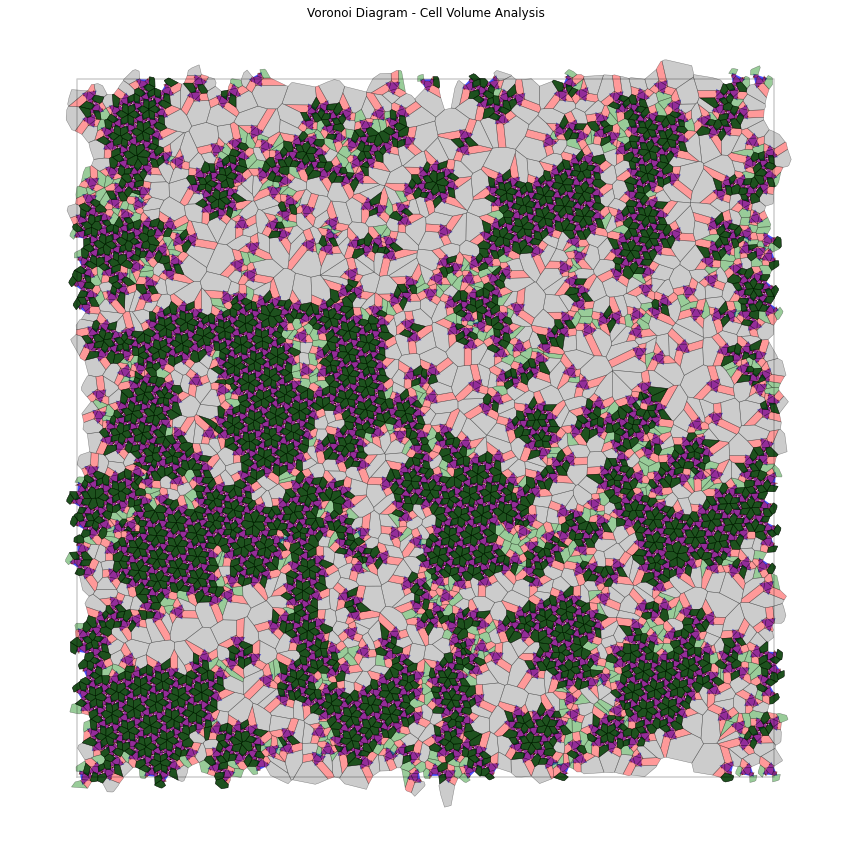

0.32735997


In [4]:
path = "../../../runs_varT_test/3asym/*/"
#path = "runs/mouse/*/"
dirlist = glob.glob(path)
for dir in dirlist:
    param = get_param_from_dir(dir)
    if param[1] != ['0.2', '0.05', '0.2', '0.25', '0.145', '1', '1']: #d r mu phi T eps id
        continue
    print(dir)
    patch_r = float(param[1][1])
    N_patches_i = get_number_of_patches(param[0])
    checkpoints = get_checkpoints(dir)

    for icp, cp in enumerate(checkpoints[1:2]):

        N_particles, positions, orient, box_xy = get_state()
        box_length = box_xy[0]

        vertices, patches = get_vertices_patches()

        #######calculate voronoi
        freud_box = freud.box.Box.square(box_length)
        vplot_points = collect_and_transform_points_for_voronoi()
        voro = freud.locality.Voronoi()
        voro.compute((freud_box, vplot_points))
        
        volume_cutoff = 0.44
        idx_centers = np.arange(0,N_particles + N_particles * N_patches_i)
        idx_pores = [idx for idx, vol in enumerate(voro.volumes) if (vol <= volume_cutoff) and (idx not in idx_centers)]
        idx_undefined = [idx for idx in range(N_particles,len(vplot_points)) if ((idx not in idx_centers) and (idx not in idx_pores))]

        ######calculate particle_clusters
        #calculate patch distances of neighbour particles

        idx_first_neighbours, idx_second_neighbours = get_voronoi_neighbours(voro.nlist)

        patches_distances = get_patch_dist_mat()


        #cluster detection over patch cells
        idx_bonded = []
        particle_clusters = nx.Graph()
        void_clusters = nx.Graph()

        for i, neighs in enumerate(idx_first_neighbours[N_particles:N_particles + N_particles*N_patches_i], start =N_particles):
            for j in neighs:
                if j >= N_particles + N_particles*N_patches_i or j<N_particles:
                    continue
                if patches_distances[i-N_particles,j-N_particles] < 2 * patch_r:
                    idx_bonded.append(i) #can be removed when drawing the bonded cells isn't necessary
                    particle_clusters.add_edge(i,j)
                    #break

                
        for im neighs in enumerate(idx_first_neighbours[])

        # post dict only necessary for networkx positions. can be removed later
        posdict = {}
        for i,pos in enumerate(vplot_points):
            posdict[i]=pos[:2]
        particle_clusters = nx.connected_components(particle_clusters)
        cluster_list = list(particle_clusters)

        idx_not_bonded=list(set(idx_centers[N_particles:N_particles + N_particles*N_patches_i]) - set(idx_bonded))

        checklist_for_pores = idx_undefined
        print(len(checklist_for_pores))

        idx_pores_of_clusters = []
        for cluster in cluster_list:
            idx_pores_of_clusters_i =[]
            for idx_particle_cell in cluster:
                check_if_part_of_pore = True
                for idx_neighbour_of_cell in idx_first_neighbours[idx_particle_cell]:
                    if idx_neighbour_of_cell in checklist_for_pores:
                        check_if_part_of_pore = False
                
                if check_if_part_of_pore:
                    idx_pores_of_clusters_i.extend(list(set(idx_first_neighbours[idx_particle_cell]).intersection(idx_pores)))
                    
            idx_pores_of_clusters.extend(np.array(idx_pores_of_clusters_i))


        idx_selection=idx_pores_of_clusters
        
        #draw_voroplot(filename="../../../python_voronoi_plot.jpeg", SAVE = True, DRAW_POLYGONS = True, DRAW_PATCHES = True, DRAW_SELECTED=True, DRAW_NX=True)

        q = calc_Steinhardt(6, freud_box, vplot_points[:len(positions)])




In [ ]:
        #cluster detection over center cells
        #for i,neighs in enumerate(idx_second_neighbours[:N_particles]):
        #    for j in neighs:
        #        if j >= N_particles:
        #            break
        #        for p1 in patchrange:
        #            for p2 in patchrange:
        #                if patches_distances[i*N_patches_i+p1,j*N_patches_i+p2] < 2 * patch_r:
        #                    idx_bonded.append(i) #can be removed when drawing the bonded cells isn't necessary
        #                    G.add_edge(i,j)
        